## Imports

In [60]:
from nb_utils import set_root

PROJECT_ROOT = set_root(4, "src")

In [61]:
from functools import partial

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
# from lightgbm import LGBMRegressor
from sklearn.base import BaseEstimator
from sklearn.datasets import make_blobs, make_regression
from sklearn.ensemble import (GradientBoostingClassifier,
                              GradientBoostingRegressor,
                              RandomForestClassifier, RandomForestRegressor)
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import (accuracy_score, cohen_kappa_score, f1_score,
                             mean_absolute_error, mean_squared_error,
                             precision_score, r2_score, recall_score)
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVC, SVR
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor

from mlpr.ml.supervisioned.classification.utils import generate_colors
from mlpr.ml.supervisioned.surrogates.surrogates import Surrogate

# from xgboost import XGBRegressor

## Parameters

In [62]:
random_state: int = 42
n_feats: int = 2
n_feats_reg: int = 1
n_size: int = 1000
centers: list[tuple] = [
    (0, 2),
    (2, 0),
    (5, 4.5)
]
n_informative: int = 2
noise: float = 5
n_class: int = len(centers)
cluster_std: list[float] = [1.4, 1.4, 1.4]
cv: int = 5

np.random.seed(random_state)

params: dict[str, dict[str, any]] = {
    "classification": {
        "n_samples": n_size,
        "n_features": n_feats,
        "centers": centers,
        "cluster_std": cluster_std,
        "random_state": random_state
    },
    "regression": {
        "n_samples": n_size,
        "n_features": n_feats_reg,
        "n_informative": n_informative,
        "noise": noise,
        "random_state": random_state
    }
}

In [63]:
def custom_precision(y_test, y_pred, **kwargs):
    return precision_score(y_test, y_pred, **kwargs)


def custom_rmse(y_test, y_pred, **kwargs):
    return -np.sqrt(mean_squared_error(y_test, y_pred, **kwargs))


def mean_absolute_percentage_error(y_true, y_pred):
    return -np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [64]:
params_split: dict[str, any] = {'test_size': 0.2, 'random_state': 42}
params_norm: dict[str, bool] = {'with_mean': True, 'with_std': True}
model_metrics: dict[str, dict[str, any]] = {
    'classification': {
        'custom_accuracy': partial(accuracy_score, normalize=False),
        'accuracy': accuracy_score,
        'custom_precision': partial(custom_precision, average="macro"),
        'recall': partial(recall_score, average='macro'),
        'kappa': cohen_kappa_score,
        'f1': partial(f1_score, average='macro'),
    },
    'regression': {
        "custom_rmse": custom_rmse,
        "custom_mape": mean_absolute_percentage_error,
        'mse': mean_squared_error,
        'mae': mean_absolute_error,
        'r2': r2_score,
    }
}

In [65]:
black_box: dict[str, dict[BaseEstimator, dict]] = {
    "classification": {
        RandomForestClassifier: {
            'n_estimators': [10, 50, 100, 200],
            'max_depth': [None, 5, 10, 15],
            'min_samples_split': [2, 5, 10],
            'min_samples_leaf': [1, 2, 4],
            'random_state': [random_state]
        },
        GradientBoostingClassifier: {
            'n_estimators': [50, 100, 200],
            'learning_rate': [0.1, 0.05, 0.01, 0.005],
            'subsample': [0.5, 0.8, 1.0],
            'random_state': [random_state]
        },
        GaussianNB: {
            'var_smoothing': [1e-9, 1e-8, 1e-7, 1e-6, 1e-5]
        },
        SVC: {
            'C': [0.01, 0.1, 1.0, 10.0],
            'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
            'degree': [2, 3, 4],
            'gamma': ['scale', 'auto'],
            'probability': [True],
            'random_state': [random_state]
        }
    },
    "regression": {
        RandomForestRegressor: {
            'n_estimators': [10, 50, 100, 200],
            'max_depth': [None, 5, 10, 15],
            'min_samples_split': [2, 5, 10],
            'min_samples_leaf': [1, 2, 4],
            'random_state': [random_state]
        },
        GradientBoostingRegressor: {
            'n_estimators': [50, 100, 200],
            'learning_rate': [0.1, 0.05, 0.01, 0.005],
            'subsample': [0.5, 0.8, 1.0],
            'random_state': [random_state]
        },
        SVR: {
            'C': [0.01, 0.1, 1.0, 10.0],
            'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
            'degree': [2, 3, 4],
            'gamma': ['scale', 'auto']
        },
        # LGBMRegressor: {
        #     'num_leaves': [31, 127],
        #     'learning_rate': [0.1, 0.01],
        #     'n_estimators': [100, 200],
        #     'random_state': [random_state]
        # },
        # XGBRegressor: {
        #     'max_depth': [6, 10],
        #     'learning_rate': [0.3, 0.1],
        #     'n_estimators': [100, 200],
        #     'random_state': [random_state]
        # }
    },
    "regression_complex": {
        RandomForestRegressor: {
            'n_estimators': [200, 300, 500],
            'max_depth': [None, 10, 20, 30],
            'min_samples_split': [2, 5, 10],
            'min_samples_leaf': [1, 2, 4],
            'random_state': [random_state]
        },
        GradientBoostingRegressor: {
            'n_estimators': [200, 300, 500],
            'learning_rate': [0.1, 0.05, 0.01, 0.005],
            'subsample': [0.5, 0.8, 1.0],
            'random_state': [random_state]
        },
        SVR: {
            'C': [1.0, 10.0, 100.0],
            'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
            'degree': [2, 3, 4],
            'gamma': ['scale', 'auto']
        },
        KNeighborsRegressor: {
            'n_neighbors': [3, 5, 10, 20],
            'weights': ['uniform', 'distance'],
            'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
            'p': [1, 2]
        },
        # LGBMRegressor: {
        #     'num_leaves': [31, 127, 255],
        #     'learning_rate': [0.1, 0.01, 0.001],
        #     'n_estimators': [200, 300, 500],
        #     'random_state': [random_state]
        # },
        # XGBRegressor: {
        #     'max_depth': [6, 10, 15],
        #     'learning_rate': [0.3, 0.1, 0.01],
        #     'n_estimators': [200, 300, 500],
        #     'random_state': [random_state]
        # }
    }
}

white_box: dict[str, dict[BaseEstimator, dict]] = {
    "classification": {
        DecisionTreeClassifier: {
            'random_state': [42],
            'max_depth': [1, 5, 10],
            'min_samples_split': [2, 5, 10]
        },
        LogisticRegression: {
            'random_state': [42],
            'penalty': ['l1', 'l2'],
            'C': [0.1, 1, 10],
            'solver': ['liblinear']
        }
    },
    "regression": {
        DecisionTreeRegressor: {
            'random_state': [42],
            'max_depth': [1, 5, 10],
            'min_samples_split': [2, 5, 10]
        },
        LinearRegression: {}
    },
    "regression_complex": {
        DecisionTreeRegressor: {
            'random_state': [42],
            'max_depth': [10, 20, 30],
            'min_samples_split': [2, 5, 10]
        },
        LinearRegression: {}
    }
}

## Classification

### Load dataset

In [66]:
X, y = make_blobs(
    **params["classification"]
)

### View the dataset

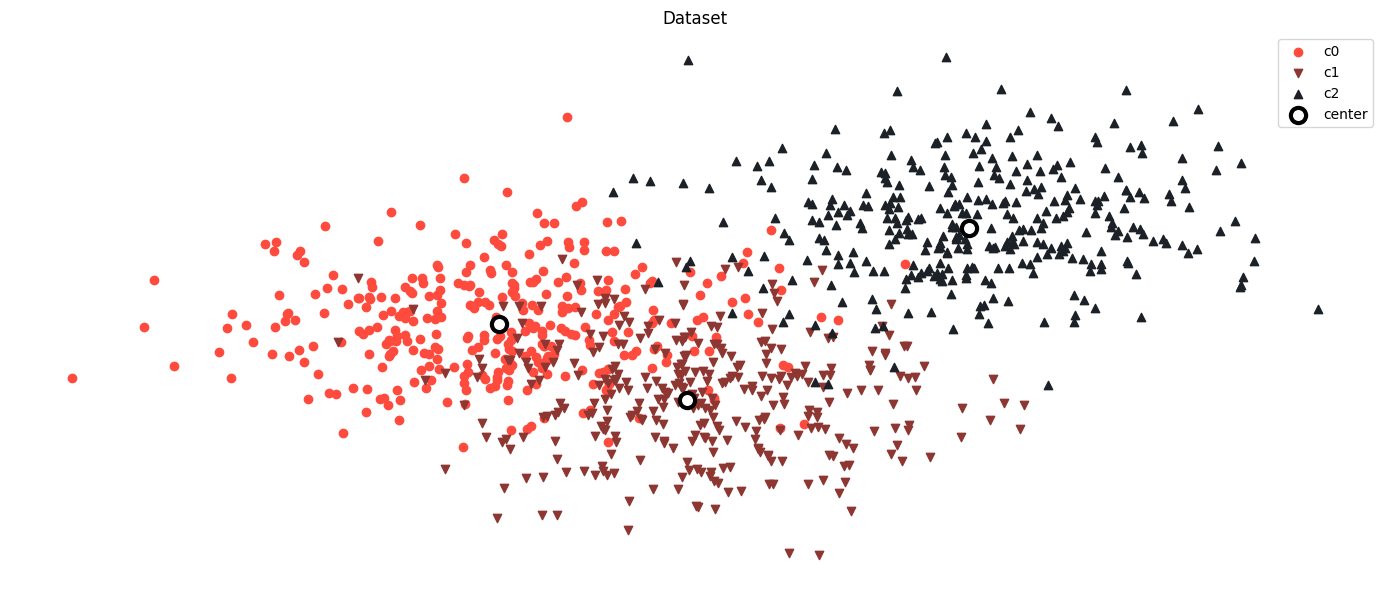

In [67]:
markers = ['o', 'v', '^']
fig, ax = plt.subplots(1, 1, figsize=(14, 6))

colors = generate_colors("FF4B3E", "1C2127", len(np.unique(y)))

for i, k in enumerate(np.unique(y)):
    ax.scatter(
        X[:, 0][y == k],
        X[:, 1][y == k],
        marker=markers[i % len(markers)],
        color=colors[i],
        label=f"c{i}"
    )

ax.set_title("Dataset")
ax.set_frame_on(False)
ax.set_xticks([])
ax.set_yticks([])
for i, (center, color) in enumerate(zip(centers, colors)):
    ax.scatter(
        center[0],
        center[1],
        color="white",
        linewidths=3,
        marker="o",
        edgecolor="black",
        s=120,
        label="center" if i == 0 else None
    )
plt.legend()
fig.tight_layout()

### Surrogate

In [68]:
surrogate = Surrogate(
    normalize=True,
    scoring="accuracy",
    white_box=white_box["classification"],
    black_box=black_box["classification"],
    params_split=params_split,
    params_norm=params_norm,
    metrics=model_metrics["classification"]
)

In [69]:
surrogate.fit(X, y, cv=cv, n_jobs=-1)

black_box_predictions, white_box_predictions = surrogate.predict(X)

  0%|          | 0/4 [00:00<?, ?it/s]

In [ ]:
surrogate

Surrogate(black_box={<class 'sklearn.svm._classes.SVC'>: {'C': [0.01, 0.1, 1.0,
                                                                10.0],
                                                          'degree': [2, 3, 4],
                                                          'gamma': ['scale',
                                                                    'auto'],
                                                          'kernel': ['linear',
                                                                     'poly',
                                                                     'rbf',
                                                                     'sigmoid'],
                                                          'probability': [True],
                                                          'random_state': [42]},
                     <class 'sklearn.ensemble._forest.RandomForestClassifier'>: {'max_depth': [None,
                                                                                               5,
                                                                                               10,
                                                                                               15],
                                                                                 'min_samples_leaf': [1,
                                                                                                      2,
                                                                                                      4],
                                                                                 'min_samples_split': [2,
                                                                                                       5,
                                                                                                       10],
                                                                                 'n...
          params_norm={'with_mean': True, 'with_std': True},
          params_split={'random_state': 42, 'test_size': 0.2},
          scoring='accuracy',
          white_box={<class 'sklearn.tree._classes.DecisionTreeClassifier'>: {'max_depth': [1,
                                                                                            5,
                                                                                            10],
                                                                              'min_samples_split': [2,
                                                                                                    5,
                                                                                                    10],
                                                                              'random_state': [42]},
                     <class 'sklearn.linear_model._logistic.LogisticRegression'>: {'C': [0.1,
                                                                                         1,
                                                                                         10],
                                                                                   'penalty': ['l1',
                                                                                               'l2'],
                                                                                   'random_state': [42],
                                                                                   'solver': ['liblinear']}})

### Evaluation

In [ ]:
pd.DataFrame(surrogate.grid_search_black._metrics).T

,custom_accuracy,accuracy,custom_precision,recall,kappa,f1
RandomForestClassifier,177.0,0.885,0.877540,0.881995,0.826500,0.878269
GradientBoostingClassifier,176.0,0.880,0.871977,0.875705,0.818943,0.872724
GaussianNB,184.0,0.920,0.913677,0.917034,0.879099,0.914859
SVC,185.0,0.925,0.919055,0.923323,0.886745,0.920408


In [ ]:
pd.DataFrame(surrogate.grid_search_white._metrics).T

,custom_accuracy,accuracy,custom_precision,recall,kappa,f1
DecisionTreeClassifier,39.0,0.975,0.97619,0.979167,0.962157,0.976902
LogisticRegression,40.0,1.000,1.00000,1.000000,1.000000,1.000000


In [ ]:
surrogate.best_model_white

LogisticRegression(C=10, penalty='l1', random_state=42, solver='liblinear')

In [ ]:
surrogate.best_model_black

SVC(C=0.01, degree=2, kernel='linear', probability=True, random_state=42)

## Regression

### Load dataset

In [ ]:
X, y = make_regression(
    **params["regression"]
)

### View the dataset

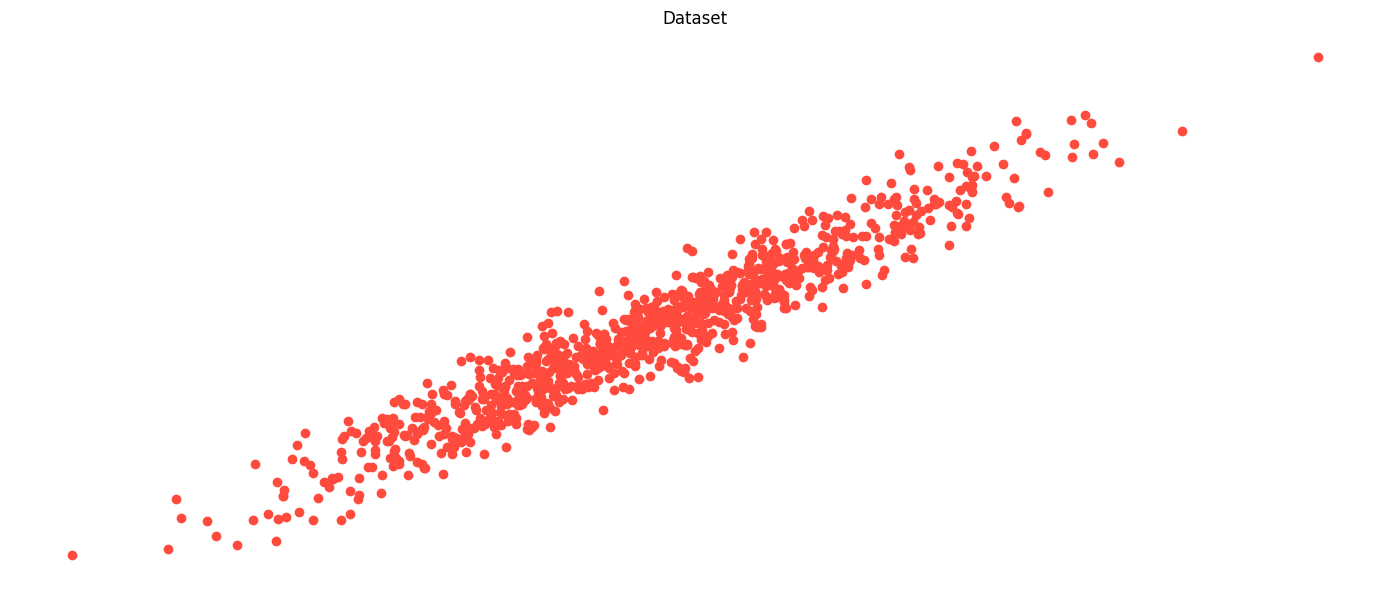

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(14, 6))

ax.scatter(
    X[:, 0],
    y,
    color="#FF4B3E"
)

ax.set_title("Dataset")
ax.set_frame_on(False)

ax.set_xticks([])
ax.set_yticks([])

fig.tight_layout()

### Surrogate

In [ ]:
surrogate = Surrogate(
    normalize=True,
    scoring="custom_rmse",
    white_box=white_box["regression"],
    black_box=black_box["regression"],
    params_split=params_split,
    params_norm=params_norm,
    metrics=model_metrics["regression"]
)

In [ ]:
surrogate.fit(X, y, cv=cv, n_jobs=-1, fitted_x=True)

black_box_predictions, white_box_predictions = surrogate.predict(X)

 60%|██████    | 3/5 [00:34<00:18,  9.11s/it]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004275 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 214
[LightGBM] [Info] Number of data points in the train set: 640, number of used features: 1
[LightGBM] [Info] Start training from score 0.437418
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.020430 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 214
[LightGBM] [Info] Number of data points in the train set: 640, number of used features: 1
[LightGBM] [Info] Start 

 80%|████████  | 4/5 [01:48<00:34, 34.52s/it]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

100%|██████████| 2/2 [00:00<00:00, 12.18it/s]


In [ ]:
surrogate

Surrogate(black_box={<class 'sklearn.svm._classes.SVR'>: {'C': [0.01, 0.1, 1.0,
                                                                10.0],
                                                          'degree': [2, 3, 4],
                                                          'gamma': ['scale',
                                                                    'auto'],
                                                          'kernel': ['linear',
                                                                     'poly',
                                                                     'rbf',
                                                                     'sigmoid']},
                     <class 'sklearn.ensemble._forest.RandomForestRegressor'>: {'max_depth': [None,
                                                                                              5,
                                                                                              10,
                                                                                              15],
                                                                                'min_samples_leaf': [1,
                                                                                                     2,
                                                                                                     4],
                                                                                'min_samples_split': [2,
                                                                                                      5,
                                                                                                      10],
                                                                                'n_estimators': [10,
                                                                                                 50,
                                                                                                 100,
                                                                                                 200],
                                                                                'random_state...
                   'r2': <function r2_score at 0x7f247200b0a0>},
          params_norm={'with_mean': True, 'with_std': True},
          params_split={'random_state': 42, 'test_size': 0.2},
          scoring='custom_rmse',
          white_box={<class 'sklearn.linear_model._base.LinearRegression'>: {},
                     <class 'sklearn.tree._classes.DecisionTreeRegressor'>: {'max_depth': [1,
                                                                                           5,
                                                                                           10],
                                                                             'min_samples_split': [2,
                                                                                                   5,
                                                                                                   10],
                                                                             'random_state': [42]}})

### Evaluation

In [ ]:
pd.DataFrame(surrogate.grid_search_black._metrics).T

,custom_rmse,custom_mape,mse,mae,r2
RandomForestRegressor,-5.343342,148.825117,28.551306,4.180112,0.908049
GradientBoostingRegressor,-5.350196,153.060347,28.624601,4.200263,0.907813
SVR,-5.184215,159.849771,26.876087,4.078210,0.913444
LGBMRegressor,-5.600867,168.727685,31.369711,4.423619,0.898972
XGBRegressor,-5.731832,177.285981,32.853902,4.489688,0.894192


In [ ]:
pd.DataFrame(surrogate.grid_search_white._metrics).T

,custom_rmse,custom_mape,mse,mae,r2
DecisionTreeRegressor,-3.113424e+00,3.348710e+00,9.693408e+00,9.555735e-01,0.975006
LinearRegression,-1.863571e-13,6.422375e-13,3.472899e-26,1.100509e-13,1.000000


In [ ]:
surrogate.best_model_white

LinearRegression()

In [ ]:
surrogate.best_model_black

SVR(C=10.0, degree=2, kernel='linear')

## Regression: Complex scenary

### Load dataset

In [ ]:
X = np.linspace(-10, 10, n_size).reshape(-1, 1)
noise = np.random.normal(0, 0.2, X.shape)
y = np.sin(X)
y = y + noise

In [ ]:
n_valid = int(n_size * 0.2)  # 20% of n_size

X_valid = np.linspace(-10, 10, n_valid).reshape(-1, 1)
noise_valid = np.random.normal(0, 0.2, X_valid.shape)
y_valid = np.sin(X_valid)
y_valid = y_valid + noise_valid

### View the dataset

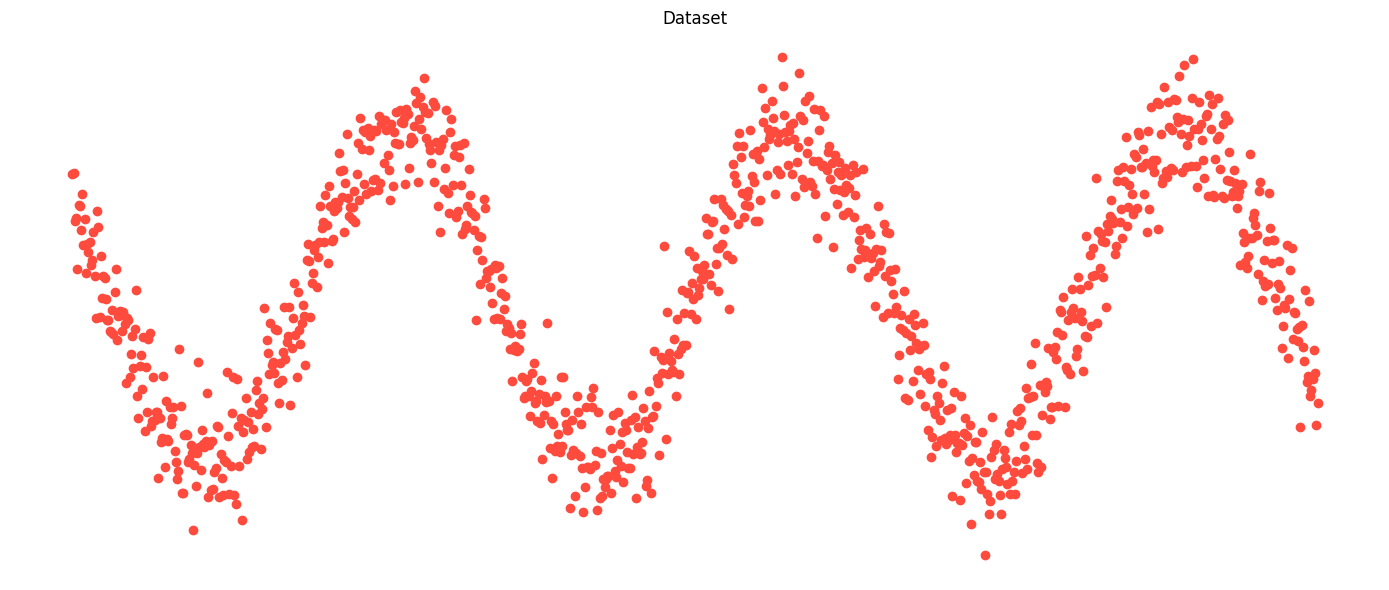

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(14, 6))

ax.scatter(
    X[:, 0],
    y,
    color="#FF4B3E"
)

ax.set_title("Dataset")
ax.set_frame_on(False)

ax.set_xticks([])
ax.set_yticks([])

fig.tight_layout()

### Surrogate

In [ ]:
surrogate = Surrogate(
    normalize=True,
    scoring="custom_rmse",
    white_box=white_box["regression_complex"],
    black_box=black_box["regression_complex"],
    params_split=params_split,
    params_norm=params_norm,
    metrics=model_metrics["regression"]
)

In [ ]:
surrogate.fit(X, y[:, 0], cv=2, n_jobs=-1, fitted_x=True)

 67%|██████▋   | 4/6 [00:36<00:11,  5.59s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012364 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 134
[LightGBM] [Info] Number of data points in the train set: 400, number of used features: 1
[LightGBM] [Info] Start training from score -0.018545
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, be

100%|██████████| 2/2 [00:00<00:00, 26.37it/s]


Surrogate(black_box={<class 'sklearn.svm._classes.SVR'>: {'C': [1.0, 10.0,
                                                                100.0],
                                                          'degree': [2, 3, 4],
                                                          'gamma': ['scale',
                                                                    'auto'],
                                                          'kernel': ['linear',
                                                                     'poly',
                                                                     'rbf',
                                                                     'sigmoid']},
                     <class 'sklearn.neighbors._regression.KNeighborsRegressor'>: {'algorithm': ['auto',
                                                                                                 'ball_tree',
                                                                                                 'kd_tree',
                                                                                                 'brute'],
                                                                                   'n_neighbors': [3,
                                                                                                   5,
                                                                                                   10,
                                                                                                   20],
                                                                                   'p': [1,
                                                                                         2],
                                                                                   'weights': ['uniform',
                                                                                               'distance']},
                     <class...
                   'r2': <function r2_score at 0x7f247200b0a0>},
          params_norm={'with_mean': True, 'with_std': True},
          params_split={'random_state': 42, 'test_size': 0.2},
          scoring='custom_rmse',
          white_box={<class 'sklearn.linear_model._base.LinearRegression'>: {},
                     <class 'sklearn.tree._classes.DecisionTreeRegressor'>: {'max_depth': [10,
                                                                                           20,
                                                                                           30],
                                                                             'min_samples_split': [2,
                                                                                                   5,
                                                                                                   10],
                                                                             'random_state': [42]}})

In [ ]:
black_box_predictions, white_box_predictions = surrogate.predict(X_valid)

In [ ]:
surrogate

Surrogate(black_box={<class 'sklearn.svm._classes.SVR'>: {'C': [1.0, 10.0,
                                                                100.0],
                                                          'degree': [2, 3, 4],
                                                          'gamma': ['scale',
                                                                    'auto'],
                                                          'kernel': ['linear',
                                                                     'poly',
                                                                     'rbf',
                                                                     'sigmoid']},
                     <class 'sklearn.neighbors._regression.KNeighborsRegressor'>: {'algorithm': ['auto',
                                                                                                 'ball_tree',
                                                                                                 'kd_tree',
                                                                                                 'brute'],
                                                                                   'n_neighbors': [3,
                                                                                                   5,
                                                                                                   10,
                                                                                                   20],
                                                                                   'p': [1,
                                                                                         2],
                                                                                   'weights': ['uniform',
                                                                                               'distance']},
                     <class...
                   'r2': <function r2_score at 0x7f247200b0a0>},
          params_norm={'with_mean': True, 'with_std': True},
          params_split={'random_state': 42, 'test_size': 0.2},
          scoring='custom_mape',
          white_box={<class 'sklearn.linear_model._base.LinearRegression'>: {},
                     <class 'sklearn.tree._classes.DecisionTreeRegressor'>: {'max_depth': [10,
                                                                                           20,
                                                                                           30],
                                                                             'min_samples_split': [2,
                                                                                                   5,
                                                                                                   10],
                                                                             'random_state': [42]}})

### Evaluation

In [ ]:
pd.DataFrame(surrogate.grid_search_black._metrics).T

,custom_rmse,custom_mape,mse,mae,r2
RandomForestRegressor,-0.233230,-65.057511,0.054396,0.185188,0.897006
GradientBoostingRegressor,-0.303114,-64.686613,0.091878,0.243776,0.826038
SVR,-0.223993,-62.208525,0.050173,0.180498,0.905002
KNeighborsRegressor,-0.219323,-60.411890,0.048103,0.174963,0.908922
LGBMRegressor,-0.252997,-60.162844,0.064008,0.203538,0.878808
XGBRegressor,-0.251543,-59.612572,0.063274,0.200088,0.880197


In [ ]:
pd.DataFrame(surrogate.grid_search_white._metrics).T

,custom_rmse,custom_mape,mse,mae,r2
DecisionTreeRegressor,-0.073172,-154.467192,0.005354,0.029875,0.983602
LinearRegression,-0.591742,-102.223200,0.350158,0.524549,-0.072414


In [ ]:
surrogate.best_model_white

LinearRegression()

In [ ]:
surrogate.best_model_black

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=10, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=200, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

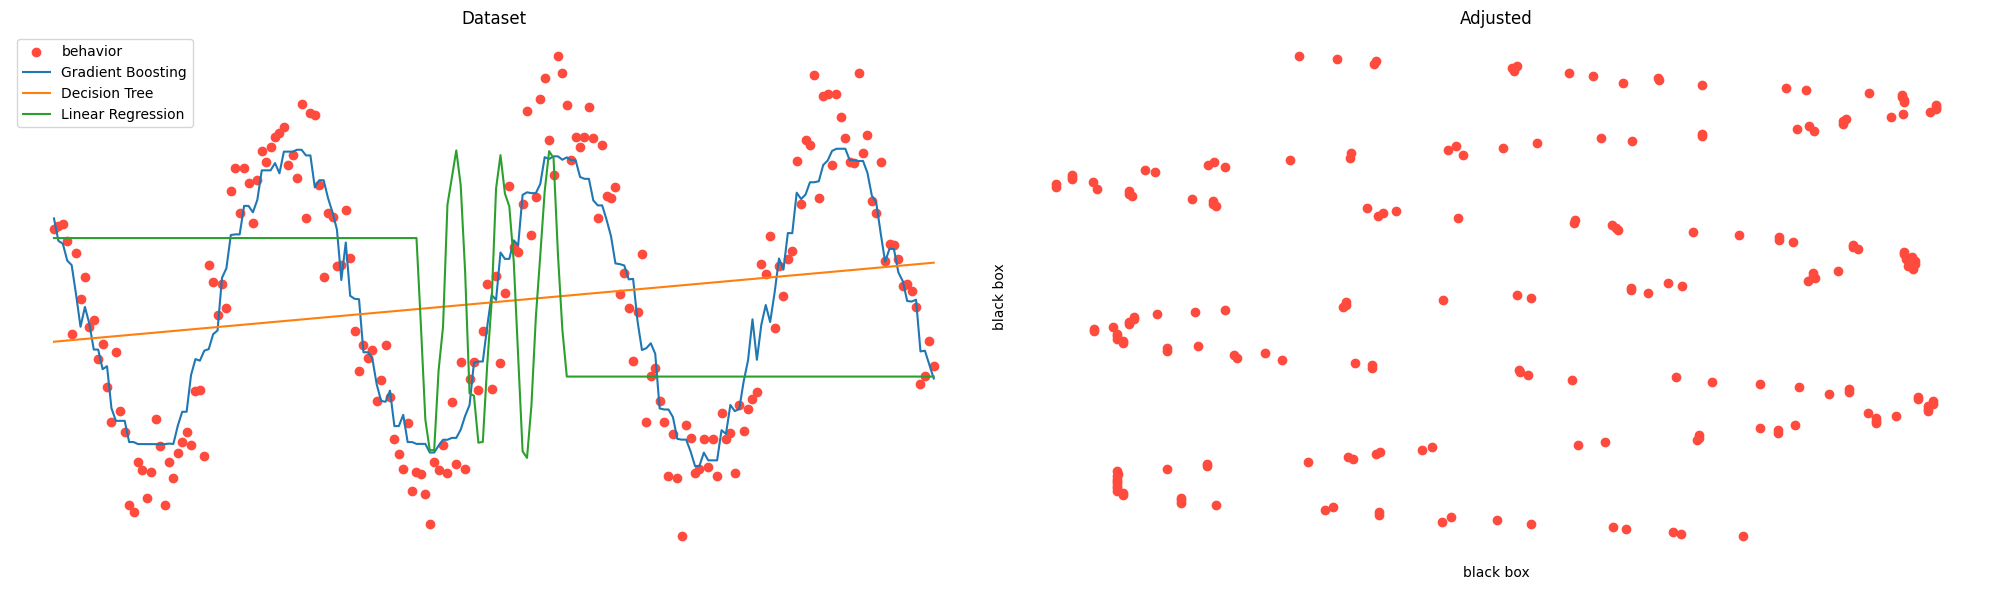

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(20, 6))

ax[0].scatter(
    X_valid[:, 0],
    y_valid,
    color="#FF4B3E",
    label="behavior"
)
ax[0].plot(
    X_valid[:, 0],
    black_box_predictions,
    label="Gradient Boosting"
)
ax[0].plot(
    X_valid[:, 0],
    white_box_predictions,
    label="Decision Tree"
)
ax[0].plot(
    X_valid[:, 0],
    surrogate.grid_search_white.fitted["LinearRegression"].predict(X_valid),
    label="Linear Regression"
)


ax[1].scatter(
    black_box_predictions,
    white_box_predictions,
    color="#FF4B3E"
)

ax[1].set_xlabel("black box")
ax[1].set_ylabel("black box")
ax[1].set_title("Adjusted")

ax[0].set_title("Dataset")
ax[0].legend()
for _ax in ax:
    _ax.set_frame_on(False)

    _ax.set_xticks([])
    _ax.set_yticks([])

fig.tight_layout()